In [1]:
pip install torch torchvision opencv-python pillow numpy pandas matplotlib seaborn scikit-learn tqdm


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.5 MB 2.0 MB/s eta 0:00:21
   ---------------------------------------- 0.2/39.5 MB 2.9 MB/s eta 0:00:14
   ---------------------------------------- 0.5/39.5 MB 4.3 MB/s eta 0:00:10
    --------------------------------------- 0.7/39.5 MB 4.9 MB/s eta 0:00:08
    --------------------------------------- 0.7/39.5 MB 4.9 MB/s eta 0:00:08
    --------------------------------------- 0.7/39.5 MB 4.9 MB/s eta 0:00:08
   - -------------------------------------- 1.7/39.5 MB 6.5 MB/s eta 0:00:06
   - -------------------------------------- 1.8/39.5 MB 5.9 MB/s eta 0:00:07
   -- ------------------------------------- 2.2/39.5 MB 6.1 MB/s eta 0:00:07
   -- --------

In [42]:
# TIEN XU LY
# RESIZE, CHUAN HOA, AUGMENTATION
# LAY DATALOADER
import torch
from torchvision import datasets, transforms # dung de RESIZE, CHUAN HOA, AUGMENTATION
from torch.utils.data import DataLoader

# transform train voi augmentation, resize, normalize
transforms_train = transforms.Compose([
    transforms.Resize((224,224)), # resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # doi do sang, tuong phan, do bao hoa, sac do
    transforms.RandomHorizontalFlip(p=0.5), #flip voi xac suat 0.5
    transforms.RandomRotation(degrees=20), #rotate
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # dich anh max 10% theo ngang or doc
    transforms.ToTensor() # scale tu [0,255] ve [0, 1], chuyen anh PIl or numpy array sang tensor pytorch
])
# simple augmentation cho test, val
transforms_test_val = transforms.Compose([
    transforms.Resize((224, 224)), #resize
    transforms.ToTensor()
])

# lay cac train, val, test dataset tu cac folder da split
train_set = datasets.ImageFolder("D:/REAL PROJECT/dataset/train", transform=transforms_train) 
test_set = datasets.ImageFolder("D:/REAL PROJECT/dataset/test", transform=transforms_test_val)
val_set = datasets.ImageFolder("D:/REAL PROJECT/dataset/val", transform=transforms_test_val)

# Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

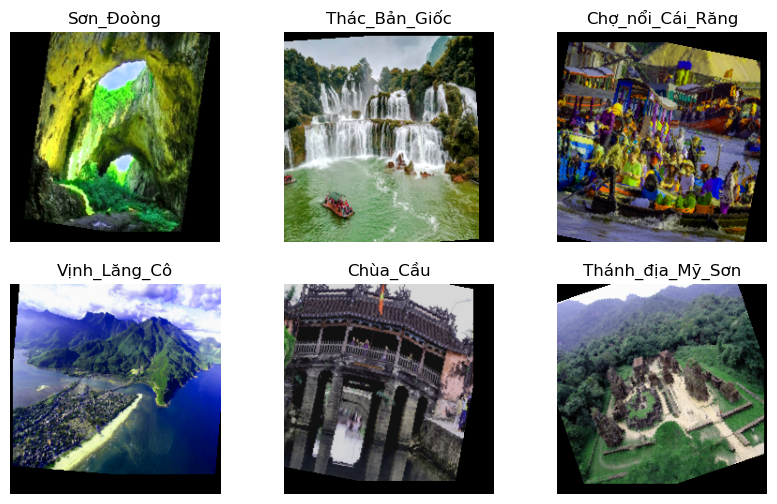

In [44]:
import matplotlib.pyplot as plt
import torchvision

# Lấy 1 batch từ train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Hiển thị 6 ảnh đầu tiên trong batch
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(6):
    ax = axes[i//3, i%3]
    img = images[i]  # (C, H, W)
    img = img.permute(1, 2, 0)  # chuyển thành (H, W, C) để hiển thị

    ax.imshow(img.numpy())
    ax.set_title(f"{train_set.classes[labels[i]]}")
    ax.axis('off')

plt.show()


In [65]:
# khởi tạo tham số, model
import torch.optim as optim
import torch.nn as nn
from model import CNN

lr = 0.001
epochs = 100
num_classes = 48
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss() # loss
optimizer = optim.Adam(model.parameters(), lr=lr) # dung Adam 

In [66]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [67]:
import copy

train_loss = []
train_accuracy = []
val_losses = []
val_acc = []

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())  # model tốt nhất

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       patience=5, factor=0.5, verbose=True)

for ep in range(epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:     
        # pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backpropagation
        # xoa gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tinh loss
        running_loss += loss.item() # tinh tong loss qua 1 ep
        _, predicted = torch.max(outputs, 1) # lay ra du doan(cai xac suat lon nhat)
        total += labels.size(0) # batchsize 
        correct += (predicted == labels).sum().item() # so du doan dung
    
    train_loss.append(running_loss / len(train_loader)) # them loss cua 1 ep vao list
    train_accuracy.append((correct / total) *100) # them accuracy 1 ep vao list
    print(f"Epoch: {ep + 1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * (correct/total):.2f}%")
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0) # batchsize
            val_correct += (predicted == labels).sum().item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_correct = 100 * val_correct / val_total
    val_acc.append(val_correct)
    
    scheduler.step(val_loss)  # update lr nếu cần
    print(f"Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_correct:.2f}%")
    
    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(">> Saved best model")

# Load best model
model.load_state_dict(best_model_wts)
print("✅ Loaded best model weights")

c:\Users\ADMIN\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1, Loss: 3.9781, Accuracy: 1.56%
Val_Loss: 3.8696, Val_Accuracy: 4.17%
>> Saved best model
Epoch: 2, Loss: 3.8704, Accuracy: 2.73%
Val_Loss: 3.8655, Val_Accuracy: 4.17%
>> Saved best model
Epoch: 3, Loss: 3.8555, Accuracy: 4.04%
Val_Loss: 3.8125, Val_Accuracy: 3.12%
>> Saved best model
Epoch: 4, Loss: 3.7673, Accuracy: 4.69%
Val_Loss: 3.6114, Val_Accuracy: 4.17%
>> Saved best model
Epoch: 5, Loss: 3.6629, Accuracy: 5.34%
Val_Loss: 3.5777, Val_Accuracy: 5.21%
>> Saved best model
Epoch: 6, Loss: 3.5934, Accuracy: 5.86%
Val_Loss: 3.5360, Val_Accuracy: 5.21%
>> Saved best model
Epoch: 7, Loss: 3.5483, Accuracy: 6.51%
Val_Loss: 3.4914, Val_Accuracy: 9.38%
>> Saved best model
Epoch: 8, Loss: 3.5168, Accuracy: 5.99%
Val_Loss: 3.4132, Val_Accuracy: 10.42%
>> Saved best model
Epoch: 9, Loss: 3.4679, Accuracy: 6.38%
Val_Loss: 3.4109, Val_Accuracy: 9.38%
>> Saved best model
Epoch: 10, Loss: 3.4224, Accuracy: 10.29%
Val_Loss: 3.3587, Val_Accuracy: 12.50%
>> Saved best model
Epoch: 11, Loss:

In [ ]:
# TESTING
model.eval()

test_acc = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_acc += (predicted == labels).sum().item()
accuracy = 100 * (test_acc / test_total)
print(f"Accuracy: {accuracy:.2f}%") 


Accuracy: 31.25%


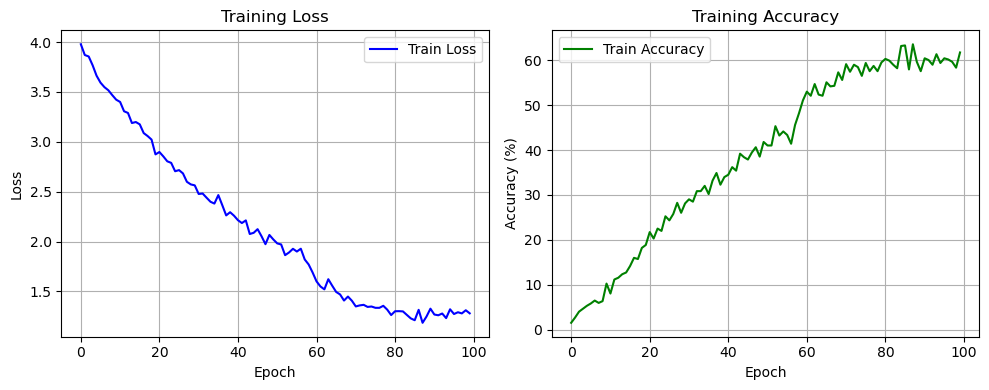

In [69]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


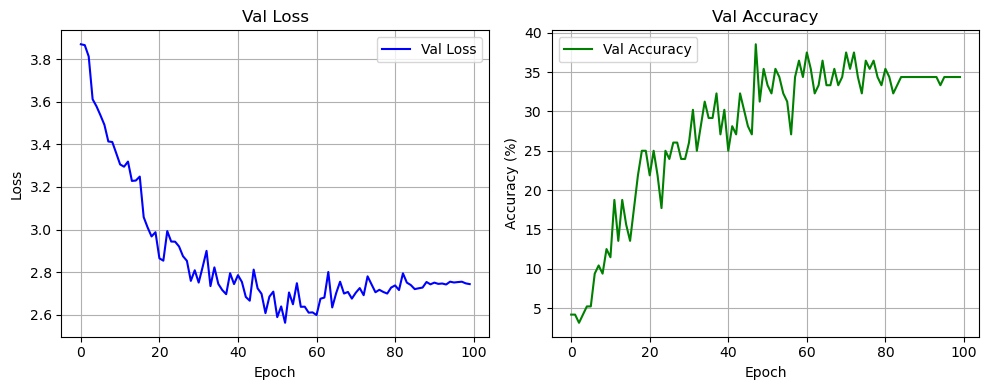

In [70]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Val Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [72]:
# DÙNG RESNET
from torchvision import models
import copy

model = models.resnet18(pretrained=True)
# thay đổi lớp FC cuối
model.fc = nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

train_loss = []
train_accuracy = []
val_losses = []
val_acc = []

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())  # model tốt nhất

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       patience=5, factor=0.5, verbose=True)

for ep in range(epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:     
        # pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backpropagation
        # xoa gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tinh loss
        running_loss += loss.item() # tinh tong loss qua 1 ep
        _, predicted = torch.max(outputs, 1) # lay ra du doan(cai xac suat lon nhat)
        total += labels.size(0) # batchsize 
        correct += (predicted == labels).sum().item() # so du doan dung
    
    train_loss.append(running_loss / len(train_loader)) # them loss cua 1 ep vao list
    train_accuracy.append((correct / total) *100) # them accuracy 1 ep vao list
    print(f"Epoch: {ep + 1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * (correct/total):.2f}%")
    
    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0) # batchsize
            val_correct += (predicted == labels).sum().item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_correct = 100 * val_correct / val_total
    val_acc.append(val_correct)
    
    scheduler.step(val_loss)  # update lr nếu cần
    print(f"Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_correct:.2f}%")
    
    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(">> Saved best model")

# Load best model
model.load_state_dict(best_model_wts)
print("✅ Loaded best model weights")

c:\Users\ADMIN\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ADMIN\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1, Loss: 2.8303, Accuracy: 30.73%
Val_Loss: 3.6315, Val_Accuracy: 30.21%
>> Saved best model
Epoch: 2, Loss: 1.5523, Accuracy: 58.20%
Val_Loss: 2.2302, Val_Accuracy: 43.75%
>> Saved best model
Epoch: 3, Loss: 1.0337, Accuracy: 71.88%
Val_Loss: 1.9562, Val_Accuracy: 46.88%
>> Saved best model
Epoch: 4, Loss: 0.7536, Accuracy: 79.17%
Val_Loss: 1.7602, Val_Accuracy: 54.17%
>> Saved best model
Epoch: 5, Loss: 0.6720, Accuracy: 81.77%
Val_Loss: 1.9779, Val_Accuracy: 53.12%
Epoch: 6, Loss: 0.4829, Accuracy: 87.50%
Val_Loss: 1.1453, Val_Accuracy: 70.83%
>> Saved best model
Epoch: 7, Loss: 0.3912, Accuracy: 89.58%
Val_Loss: 1.6913, Val_Accuracy: 62.50%
Epoch: 8, Loss: 0.3149, Accuracy: 91.15%
Val_Loss: 1.4707, Val_Accuracy: 59.38%
Epoch: 9, Loss: 0.3445, Accuracy: 89.58%
Val_Loss: 1.4192, Val_Accuracy: 63.54%
Epoch: 10, Loss: 0.2812, Accuracy: 90.76%
Val_Loss: 1.8360, Val_Accuracy: 65.62%
Epoch: 11, Loss: 0.2576, Accuracy: 92.45%
Val_Loss: 1.6017, Val_Accuracy: 64.58%
Epoch: 12, Loss: 0

In [73]:
torch.save(best_model_wts, "best_model.pth")

In [74]:
# TESTING
model.eval()

test_acc = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_acc += (predicted == labels).sum().item()
accuracy = 100 * (test_acc / test_total)
print(f"Accuracy: {accuracy:.2f}%") 

Accuracy: 72.92%


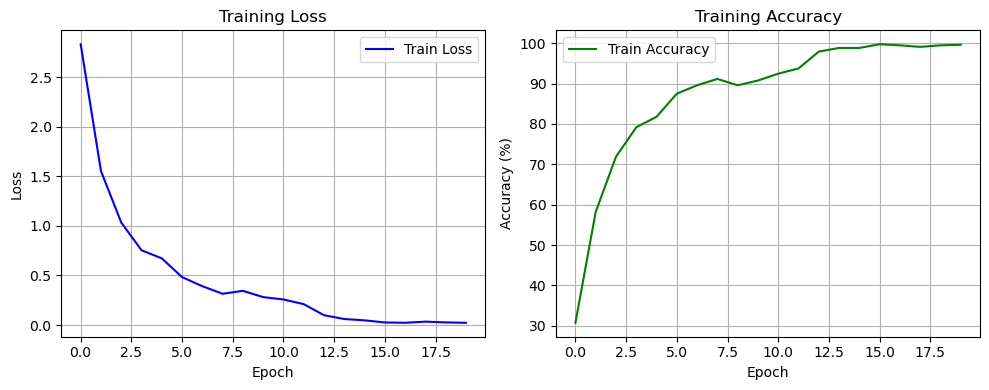

In [75]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


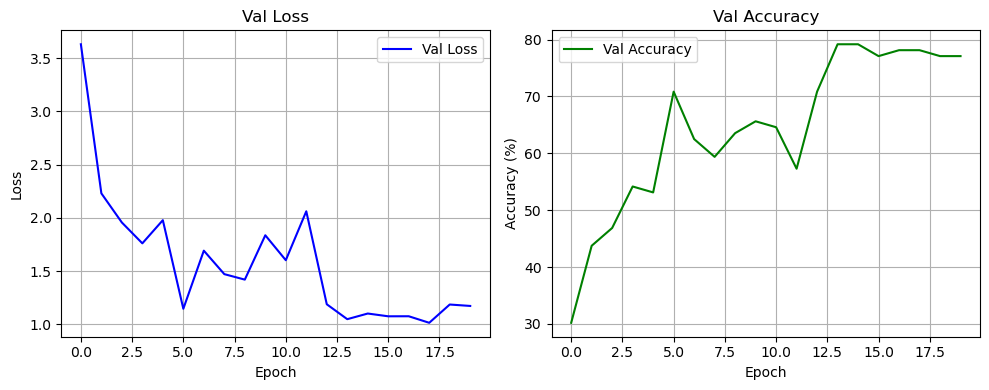

In [76]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Val Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [77]:
train_set.classes

['Bà_Nà_Hills',
 'Bãi_Sao',
 'Bưu_điện_Trung_tâm_Sài_Gòn',
 'Chùa_Bái_Đính',
 'Chùa_Cầu',
 'Chùa_Một_Cột',
 'Chùa_Thiên_Mụ',
 'Chợ_Bắc_Hà',
 'Chợ_Bến_Thành',
 'Chợ_nổi_Cái_Răng',
 'Công_viên_Thiên_văn_học',
 'Cố_đô_Hoa_Lư',
 'Cố_đô_Huế',
 'Dinh_Độc_Lập',
 'Fansipan',
 'Hang_Pác_Bó',
 'Hàm_Cá_Mập',
 'Hồ_Ba_Bể',
 'Hồ_Hoàn_Kiếm',
 'Lăng_Chủ_tịch_Hồ_Chí_Minh',
 'Lăng_Tự_Đức',
 'Lũng_Cú',
 'Ngũ_Hành_Sơn',
 'Nhà_Thờ_Đá',
 'Nhà_thờ_lớn_Hà_Nội',
 'Nhà_thờ_Đức_Bà_Sài_Gòn',
 'Núi_Cấm',
 'Núi_Yên_Tử',
 'Phố_cổ_Hà_Nội',
 'Phố_cổ_Hội_An',
 'Quảng_trường_Lâm_Viên',
 'Ruộng_bậc_thang_Sa_Pa',
 'Rừng_tràm_Trà_Sư',
 'Sông_Hương',
 'Sơn_Đoòng',
 'Tam_Cốc_-_Bích_Động',
 'Thác_Bản_Giốc',
 'Thánh_địa_Mỹ_Sơn',
 'Tràng_An',
 'Văn_Miếu_-_Quốc_Tử_Giám',
 'Vịnh_Hạ_Long',
 'Vịnh_Lăng_Cô',
 'Đèo_Ô_Quy_Hồ',
 'Đảo_Phú_Quốc',
 'Đỉnh_Bàn_Cờ',
 'Địa_đạo_Củ_Chi',
 'Động_Phong_Nha',
 'Động_Thiên_Đường']

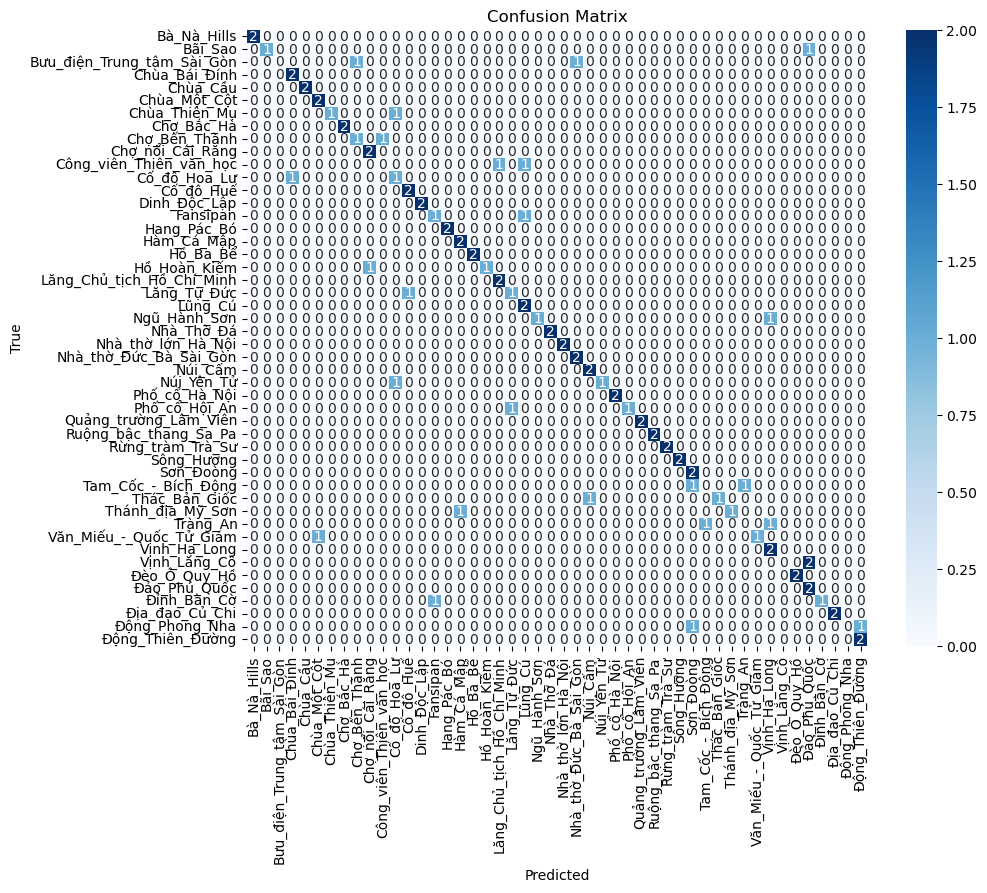

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_set.classes, yticklabels=train_set.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [83]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=train_set.classes))

                            precision    recall  f1-score   support

               Bà_Nà_Hills       1.00      1.00      1.00         2
                   Bãi_Sao       1.00      0.50      0.67         2
Bưu_điện_Trung_tâm_Sài_Gòn       0.00      0.00      0.00         2
             Chùa_Bái_Đính       0.67      1.00      0.80         2
                  Chùa_Cầu       1.00      1.00      1.00         2
              Chùa_Một_Cột       0.67      1.00      0.80         2
             Chùa_Thiên_Mụ       1.00      0.50      0.67         2
                Chợ_Bắc_Hà       1.00      1.00      1.00         2
             Chợ_Bến_Thành       0.50      0.50      0.50         2
          Chợ_nổi_Cái_Răng       0.67      1.00      0.80         2
   Công_viên_Thiên_văn_học       0.00      0.00      0.00         2
              Cố_đô_Hoa_Lư       0.33      0.50      0.40         2
                 Cố_đô_Huế       0.67      1.00      0.80         2
              Dinh_Độc_Lập       1.00      1.00

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
